In [24]:
import os
import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision import transforms
# from dataset.data_loader import GetLoader
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
from skimage import io, transform
import cv2
import numpy as np
import pandas as pd


class MNIST(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """ Intialize the MNIST dataset """
        self.root_dir = root_dir
        self.landmarks_frame = pd.read_csv(csv_file)
        self.transform = transform
                              
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        img_name = os.path.join(self.root_dir,self.landmarks_frame.iloc[index,0])
        image = io.imread(img_name)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = self.landmarks_frame['label'][index]
        label = torch.FloatTensor([label])

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        """ Total number of samples in the dataset """
        return len(self.landmarks_frame)

dataset_name = "SVHN"
epoch = 1
assert dataset_name in ['MNIST', 'SVHN']

model_root = os.path.join('.','model')
image_root = os.path.join('..', 'dataset', dataset_name)

cuda = True
cudnn.benchmark = True
batch_size = 1
image_size = 28
alpha = 0

"""load data"""

# img_transform_source = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])

# img_transform_target = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])

if dataset_name == 'SVHN':
    # test_list = os.path.join(image_root, 'mnist_m_test_labels.txt')

    # dataset = GetLoader(
    #     data_root=os.path.join(image_root, 'mnist_m_test'),
    #     data_list=test_list,
    #     transform=img_transform_target
    # )
    dataset =  MNIST(csv_file="../../hw3_data/digits/svhn/test.csv", root_dir="../../hw3_data/digits/svhn/test",transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
else:
    dataset = MNIST(csv_file="../../hw3_data/digits/mnistm/test.csv", root_dir="../../hw3_data/digits/mnistm/test",transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

""" training """

my_net = torch.load(os.path.join(
    model_root, 'mnist_svhn_model' + str(epoch) + '.pth'
))
my_net = my_net.eval()

if cuda:
    my_net = my_net.cuda()

len_dataloader = len(dataloader)
data_target_iter = iter(dataloader)

i = 0
n_total = 0
n_correct = 0
features = []
labels = []
while i < len_dataloader:

    # test model using target data
    data_target = data_target_iter.next()
    t_img, t_label = data_target

    batch_size = len(t_label)

    input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
    class_label = torch.LongTensor(batch_size)

    if cuda:
        t_img = t_img.cuda()
        t_label = t_label.cuda()
        input_img = input_img.cuda()
        class_label = class_label.cuda()

    input_img.resize_as_(t_img).copy_(t_img)
    class_label.resize_as_(t_label.long()).copy_(t_label.long())

    _, _,feature = my_net(input_data=input_img, alpha=alpha)
#     print(feature.size())
#     print(feature.cpu())
    features.append(feature.detach().cpu().numpy())
    labels.append(t_label.detach().cpu().numpy())
#         pred = class_output.data.max(1, keepdim=True)[1]
#         n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
#         n_total += batch_size
#     print(i)
    i += 1

#     accu = n_correct.data.numpy() * 1.0 / n_total

#     print ('epoch: %d, accuracy of the %s dataset: %f' % (epoch, dataset_name, accu))

/home/robot/anaconda3/envs/env/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


AttributeError: 'list' object has no attribute 'shape'

In [25]:
labels = np.array(labels).astype("int64")

In [26]:
labels = np.squeeze(labels)
labels.shape

(26032,)

In [27]:
out = np.array(features)

In [28]:
out.shape

(26032, 1, 800)

In [29]:
out=np.squeeze(out)

In [30]:
out.shape

(26032, 800)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets


X, y = out,labels
n_samples, n_features = X.shape

In [32]:
plt.cm.Set1(y[10])

(0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0)

100%|██████████| 26032/26032 [00:05<00:00, 4700.26it/s]


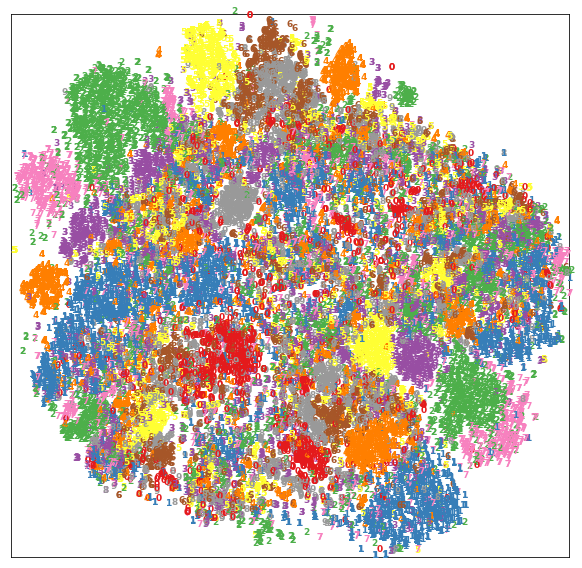

In [33]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)


'''嵌入空间可视化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(10, 10))
for i in  tqdm(range(X_norm.shape[0])):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

In [3]:
import os
import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision import transforms
# from dataset.data_loader import GetLoader
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
from skimage import io, transform
import cv2
import numpy as np
import pandas as pd

dataset_name = "USPS"
epoch = 1
class MNIST(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """ Intialize the MNIST dataset """
        self.root_dir = root_dir
        self.landmarks_frame = pd.read_csv(csv_file)
        self.transform = transform
                              
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        img_name = os.path.join(self.root_dir,self.landmarks_frame.iloc[index,0])
        image = io.imread(img_name)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = self.landmarks_frame['label'][index]
        label = torch.FloatTensor([label])

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        """ Total number of samples in the dataset """
        return len(self.landmarks_frame)

class USPS(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """ Intialize the MNIST dataset """
        self.root_dir = root_dir
        self.landmarks_frame = pd.read_csv(csv_file)
        self.transform = transform
                              
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        img_name = os.path.join(self.root_dir,self.landmarks_frame.iloc[index,0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = self.landmarks_frame['label'][index]
        label = torch.FloatTensor([label])

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        """ Total number of samples in the dataset """
        return len(self.landmarks_frame)

assert dataset_name in ['SVHN', 'USPS']

model_root = os.path.join('.','model')
image_root = os.path.join('..', 'dataset', dataset_name)

cuda = True
cudnn.benchmark = True
batch_size = 1
image_size = 28
alpha = 0

"""load data"""

# img_transform_source = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])

# img_transform_target = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])

if dataset_name == 'USPS':
    # test_list = os.path.join(image_root, 'mnist_m_test_labels.txt')

    # dataset = GetLoader(
    #     data_root=os.path.join(image_root, 'mnist_m_test'),
    #     data_list=test_list,
    #     transform=img_transform_target
    # )
    dataset =  USPS(csv_file="../../hw3_data/digits/usps/test.csv", root_dir="../../hw3_data/digits/usps/test",transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
else:
    dataset = MNIST(csv_file="../../hw3_data/digits/svhn/test.csv", root_dir="../../hw3_data/digits/svhn/test",transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

""" training """

my_net = torch.load(os.path.join(
    model_root, 'svhn_usps_model' + str(epoch) + '.pth'
))
my_net = my_net.eval()

if cuda:
    my_net = my_net.cuda()

len_dataloader = len(dataloader)
data_target_iter = iter(dataloader)

i = 0
n_total = 0
n_correct = 0
features = []
labels = []
while i < len_dataloader:

    # test model using target data
    data_target = data_target_iter.next()
    t_img, t_label = data_target

    batch_size = len(t_label)

    input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
    class_label = torch.LongTensor(batch_size)

    if cuda:
        t_img = t_img.cuda()
        t_label = t_label.cuda()
        input_img = input_img.cuda()
        class_label = class_label.cuda()

    input_img.resize_as_(t_img).copy_(t_img)
    class_label.resize_as_(t_label.long()).copy_(t_label.long())

    _, _, feature = my_net(input_data=input_img, alpha=alpha)
    features.append(feature.detach().cpu().numpy())
    labels.append(t_label.detach().cpu().numpy())
#     print(i)
    i += 1


In [18]:
labels = np.array(labels).astype("int64")
labels = np.squeeze(labels)
out = np.array(features)
out = np.squeeze(out)

array([9, 6, 3, 6, 6, 0, 0, 0, 6, 9])

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets


X, y = out,labels
n_samples, n_features = X.shape

100%|██████████| 2007/2007 [00:00<00:00, 4428.24it/s]


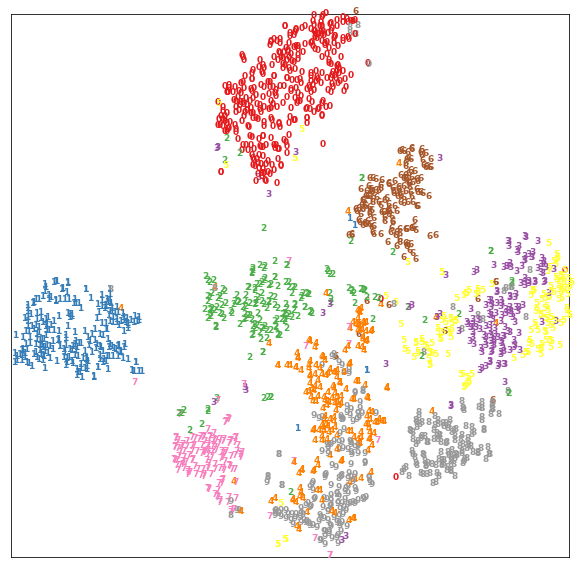

In [21]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)


'''嵌入空间可视化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(10, 10))
for i in  tqdm(range(X_norm.shape[0])):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
import os
import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision import transforms
# from dataset.data_loader import GetLoader
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
from skimage import io, transform
import cv2
import numpy as np
import pandas as pd

dataset_name = "USPS"
epoch = 1
class MNIST(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """ Intialize the MNIST dataset """
        self.root_dir = root_dir
        self.landmarks_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.d_label = 0
                              
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        img_name = os.path.join(self.root_dir,self.landmarks_frame.iloc[index,0])
        image = io.imread(img_name)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = self.landmarks_frame['label'][index]
        label = torch.FloatTensor([label])
        d_label = self.d_label
        if self.transform:
            image = self.transform(image)
        return image, label, d_label

    def __len__(self):
        """ Total number of samples in the dataset """
        return len(self.landmarks_frame)

class USPS(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """ Intialize the MNIST dataset """
        self.root_dir = root_dir
        self.landmarks_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.d_label = 1
                              
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        img_name = os.path.join(self.root_dir,self.landmarks_frame.iloc[index,0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = self.landmarks_frame['label'][index]
        label = torch.FloatTensor([label])
        d_label = self.d_label
        if self.transform:
            image = self.transform(image)
        return image, label, d_label

    def __len__(self):
        """ Total number of samples in the dataset """
        return len(self.landmarks_frame)

assert dataset_name in ['SVHN', 'USPS']

model_root = os.path.join('.','model')
image_root = os.path.join('..', 'dataset', dataset_name)

cuda = True
cudnn.benchmark = True
batch_size = 1
image_size = 28
alpha = 0

"""load data"""


target_dataset =  USPS(csv_file="../../hw3_data/digits/usps/test.csv", root_dir="../../hw3_data/digits/usps/test",transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

source_dataset = MNIST(csv_file="../../hw3_data/digits/svhn/test.csv", root_dir="../../hw3_data/digits/svhn/test",transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

target_dataloader = torch.utils.data.DataLoader(
    dataset=target_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

source_dataloader = torch.utils.data.DataLoader(
    dataset=source_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

# """ training """

my_net = torch.load(os.path.join(
    model_root, 'svhn_usps_model' + str(epoch) + '.pth'
))
my_net = my_net.eval()

if cuda:
    my_net = my_net.cuda()

len_dataloader = len(target_dataloader)
# data_target_iter = iter(target_dataloader)

i = 0
n_total = 0
n_correct = 0
features = []
labels = []
while i < len_dataloader:
# for t_img, t_label, d_label in target_dataloader:
    # test model using target data
#     data_target = data_target_iter.next()
    t_img, t_label, d_label = data_target_iter.next()
    print(t_img, t_label,d_label)
    batch_size = len(t_label)

    input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
    class_label = torch.LongTensor(batch_size)

    if cuda:
        t_img = t_img.cuda()
        t_label = t_label.cuda()
        input_img = input_img.cuda()
        class_label = class_label.cuda()

    input_img.resize_as_(t_img).copy_(t_img)
    class_label.resize_as_(t_label.long()).copy_(t_label.long())

    _, _, feature = my_net(input_data=input_img, alpha=alpha)
    features.append(feature.detach().cpu().numpy())
    labels.append(d_label.detach().cpu().numpy())
#     print(i)
    i += 1
    
len_dataloader = len(source_dataloader)
data_target_iter = iter(source_dataloader)

i = 0
n_total = 0
n_correct = 0
# features = []
# labels = []
while i < len_dataloader:
# for t_img, t_label,  in source_dataloader:
    # test model using target data
#     data_target = data_target_iter.next()
    t_img, t_label, d_label = data_target_iter.next()

    batch_size = len(t_label)

    input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
    class_label = torch.LongTensor(batch_size)

    if cuda:
        t_img = t_img.cuda()
        t_label = t_label.cuda()
        input_img = input_img.cuda()
        class_label = class_label.cuda()

    input_img.resize_as_(t_img).copy_(t_img)
    class_label.resize_as_(t_label.long()).copy_(t_label.long())

    _, _, feature = my_net(input_data=input_img, alpha=alpha)
    features.append(feature.detach().cpu().numpy())
    labels.append(d_label.detach().cpu().numpy())
#     print(i)
    i += 1

/home/robot/anaconda3/envs/env/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.CNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


KeyboardInterrupt: 

In [4]:
data_target_iter = iter(target_dataloader)

In [10]:
a,b,c = data_target_iter.next()

RuntimeError: received 0 items of ancdata

In [6]:
a

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])

In [7]:
b

tensor([[9.]])

In [8]:
c

tensor([1])